# Stack Overflow Questions by Library Data Collection

The following code was used to collect the data from the Stack Overflow API's [/search](https://api.stackexchange.com/docs/search) endpoint. Be advised that due to throttling running this code yourself will take a long time to complete.

In [1]:
import datetime as dt
import json
import re
import requests
import time

from IPython import display

libraries = [
    'pandas',
    'matplotlib',
    'numpy',
    'seaborn',
    'geopandas',
    'geoviews',
    'altair',
    'yellowbrick',
    'vega',
    'holoviews',
    'hvplot',
    'bokeh'
]
stack_overflow_tags = (
    'https://api.stackexchange.com/'
    '/2.3/search?page={}&pagesize=100&order=asc&sort=creation'
    f'&tagged={";".join(libraries)}'
    '&site=stackoverflow'
)

def throttle(wait):
    resume_time = str(dt.datetime.now() + dt.timedelta(seconds=wait))
    print(f'Waiting until {resume_time} before resuming...')
    time.sleep(wait)

done = False
questions = []
page = 1
while not done:
    display.clear_output(wait=True)
    print(f'Requesting page {page} at {str(dt.datetime.now())}...')

    response = requests.get(stack_overflow_tags.format(page))
    if not response.ok:
        if response.status_code == 400:
            message = response.json()
            if message['error_name'] == 'throttle_violation':
                print(message['error_message'])
                wait = int(re.search(r'\d+', message['error_message'])[0])
                throttle(wait)
                continue
        print(f'Request failed with status {response.status_code}')
        break
    results = response.json()
    done = not bool(results['has_more'])
    page += 1
    questions.extend([
        {
            'tags': question['tags'],
            'creation_date': question['creation_date'],
            'title': question['title']
        }
        for question in results['items']
    ])
    latest_question_creation_date = str(dt.datetime.fromtimestamp(questions[-1]['creation_date']))
    print(f'Latest question retrieved was created at {latest_question_creation_date}')
    
    # make sure we don't go too fast
    print(f'Remaining quota: {results["quota_remaining"]}')
    throttle(results.get('backoff', 1 if page % 10 else 10))
display.clear_output(wait=True)
print('Done')

with open('../stackoverflow_questions.json', 'w') as file:
    json.dump(questions, file)

Done


Questions collected:

In [2]:
len(questions)

347541

## Processing the data for files used in the workshop

In [3]:
import pandas as pd

df = pd.read_json('../stackoverflow_questions.json').assign(
    creation_date=lambda x: pd.to_datetime(x.creation_date, unit='s')
).set_index('creation_date')

df.head()

,tags,title
creation_date,,
2008-09-08 15:19:59,"[python, matlab, numpy, numerical, scientific-...",Open source alternative to MATLAB&#39;s fminco...
2008-09-21 20:23:02,"[python, numpy]",python.array versus numpy.array
2008-09-22 12:36:53,"[python, animation, matplotlib, image-scaling]",What is the fastest way to scale and display a...
2008-09-23 00:17:09,"[python, numpy, subclass, slice, ellipsis]",How do you use the ellipsis slicing syntax in ...
2008-09-23 19:49:37,"[unix, charts, graph, matplotlib]",Command-line Unix ASCII-based charting / plott...


*Source: Stack Exchange Network*

Create Boolean columns for each libary, indicating whether the question was tagged with that library:

In [4]:
df = df.assign(
    **{
        library: df.tags.apply(lambda y: f'{library}' in y)
        for library in libraries
    }
)
df.head()

,tags,title,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
creation_date,,,,,,,,,,,,,,
2008-09-08 15:19:59,"[python, matlab, numpy, numerical, scientific-...",Open source alternative to MATLAB&#39;s fminco...,False,False,True,False,False,False,False,False,False,False,False,False
2008-09-21 20:23:02,"[python, numpy]",python.array versus numpy.array,False,False,True,False,False,False,False,False,False,False,False,False
2008-09-22 12:36:53,"[python, animation, matplotlib, image-scaling]",What is the fastest way to scale and display a...,False,True,False,False,False,False,False,False,False,False,False,False
2008-09-23 00:17:09,"[python, numpy, subclass, slice, ellipsis]",How do you use the ellipsis slicing syntax in ...,False,False,True,False,False,False,False,False,False,False,False,False
2008-09-23 19:49:37,"[unix, charts, graph, matplotlib]",Command-line Unix ASCII-based charting / plott...,False,True,False,False,False,False,False,False,False,False,False,False


Pandas is the only library with more questions in this dataset tagged than not:

In [5]:
df.iloc[:,2:].describe()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
count,347541,347541,347541,347541,347541,347541,347541,347541,347541,347541,347541,347541
unique,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,False,False,False,False
freq,214919,286987,253744,340127,345889,347478,346737,347487,346943,346999,347449,343155


Save this to a CSV file:

In [6]:
df.to_csv('../stackoverflow.zip', compression=dict(method='zip', archive_name='stackoverflow.csv'))

##### Questions by tag
We will look at questions tagged with the libraries above, but there are other tags in this dataset. Out of curiosity, what are the most common tags in this dataset overall?

In [7]:
from collections import Counter

cntr = Counter()
for i in df.tags:
    cntr.update(i)

cntr.most_common()[:10]

[('python', 298687),
 ('pandas', 214919),
 ('numpy', 93797),
 ('dataframe', 60833),
 ('matplotlib', 60554),
 ('python-3.x', 37563),
 ('arrays', 17645),
 ('csv', 9415),
 ('scipy', 9096),
 ('plot', 8607)]

##### Looking at co-occurrences of libraries within a single question
How often are multiple libraries from our list tagged in a single question?

In [8]:
df.iloc[:,2:].assign(co_occurrence=lambda x: x.sum(axis=1) > 1).co_occurrence.value_counts(normalize=True)

False    0.899157
True     0.100843
Name: co_occurrence, dtype: float64

The previous result is a little misleading because a majority of the questions are about pandas. If we look at this per library, we will see that there are some libraries that are present with others most of the time:

In [9]:
co_occur = df.iloc[:,2:]\
    .assign(co_occurrence=lambda x: x.sum(axis=1) > 1)\
    .groupby('co_occurrence').sum().T
co_occur.apply(lambda x: x / co_occur.sum(axis=1))

co_occurrence,False,True
pandas,0.876600,0.123400
matplotlib,0.714552,0.285448
numpy,0.774780,0.225220
seaborn,0.282169,0.717831
geopandas,0.597458,0.402542
geoviews,0.190476,0.809524
altair,0.810945,0.189055
yellowbrick,0.740741,0.259259
vega,0.872910,0.127090
holoviews,0.374539,0.625461


##### Adjacency matrix of co-occurences
We will now create an adjacency matrix out of this information. Some questions are tagged with more than 1 additional library, so we will share the credit between them to be able to make a stacked bar plot with this information as percentages:

In [10]:
def get_co_occurrences(df, library, normalize=True):
    div = df.query(f'{library} == 1').sum(axis=1)
    data = df.query(f'{library} == 1').apply(
        lambda x: x / (div - df.query(f'{library} == 1')[library]) if x.name != library else x
    )
    co_occur = pd.Series(data.sum().values, index=df.columns)
    if normalize:
        co_occur /= co_occur[library]
    return co_occur

def get_adj_matrix(df, libraries, normalize=True, nullify_diagonal=True):
    data = df[libraries].apply(lambda x: x.astype(int))
    data.columns = data.columns.rename('library')
    adj_matrix = data.apply(lambda x: get_co_occurrences(data, x.name, False))
    sort_order = adj_matrix.sum().sort_values(ascending=False).index
    adj_matrix.index = adj_matrix.index.rename('co-occurring library')
    
    if normalize:
        adj_matrix /= data.sum()
    
    if nullify_diagonal:
        for i in range(len(libraries)):
            adj_matrix.iloc[i, i] = 0
        sort_order = adj_matrix.sum().sort_values(ascending=False).index
        adj_matrix = adj_matrix.reindex(columns=sort_order)
    else:
        for library in libraries:
            if normalize:
                adj_matrix.loc[library, library] = 2 - adj_matrix.loc[:,library].sum()
            else:
                adj_matrix.loc[library, library] = (data.query(f'{library} == 1').sum(axis=1) == 1).sum()

    return adj_matrix.reindex(sort_order).reindex(columns=sort_order)

We will build the adjacency matrix for a subset of the libraries. Note that the diagonal is set to 0 since we are calculating co-occurences only:

In [11]:
subset = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'bokeh', 'holoviews', 'geoviews', 'geopandas', 'hvplot']
co_occur_pct = get_adj_matrix(
    df, subset, normalize=True, nullify_diagonal=True
)
co_occur_pct.index = co_occur_pct.index.rename('co-occurring library')
co_occur_pct.T.to_csv('../stackoverflow_tag_co_occurrences.csv')
co_occur_pct

library,hvplot,geoviews,seaborn,holoviews,geopandas,matplotlib,numpy,bokeh,pandas
co-occurring library,,,,,,,,,
hvplot,0.000000,0.047619,0.000270,0.091636,0.002724,0.000036,0.000000,0.002318,0.000044
geoviews,0.032609,0.000000,0.000000,0.050123,0.002220,0.000041,0.000005,0.002014,0.000025
seaborn,0.021739,0.000000,0.000000,0.001845,0.002724,0.057304,0.001254,0.003382,0.007961
holoviews,0.539855,0.431217,0.000135,0.000000,0.001009,0.000275,0.000059,0.045942,0.000167
geopandas,0.048913,0.058201,0.000607,0.003075,0.000000,0.003237,0.000176,0.004408,0.001926
matplotlib,0.023551,0.039683,0.468033,0.030750,0.118644,0.000000,0.056294,0.022002,0.038191
numpy,0.000000,0.007937,0.015871,0.010148,0.009988,0.087198,0.000000,0.003078,0.073000
bokeh,0.110507,0.140212,0.002001,0.371771,0.011703,0.001594,0.000144,0.000000,0.001793
pandas,0.103261,0.084656,0.230780,0.066113,0.250504,0.135548,0.167267,0.087855,0.000000


While we won't use Seaborn in this workshop, it's very helpful at visualizing data in this format. Here, we make a heatmap:

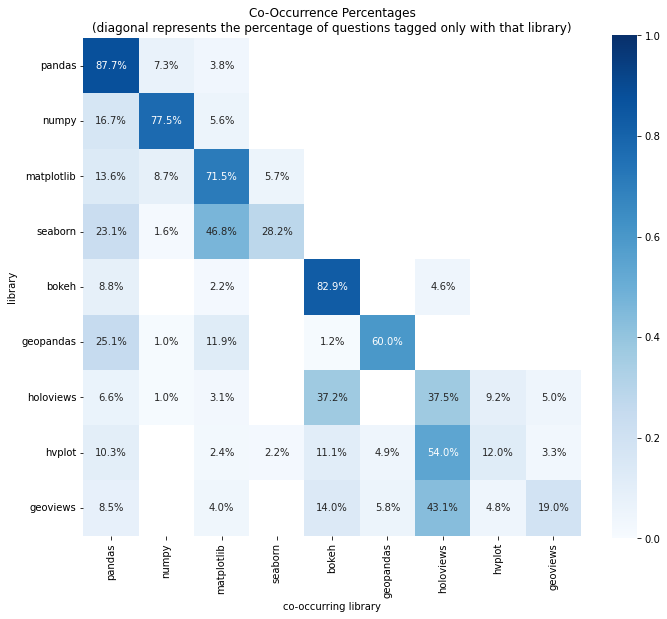

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

data = get_adj_matrix(
    df, subset, normalize=True, nullify_diagonal=False
).T

sns.heatmap(
    data, mask=data.round(4) < 0.01, annot=True, fmt='.1%',
    cmap='Blues', cbar_kws={'shrink': 0.75}, 
    square=True, vmin=0, vmax=1, center=0.5, ax=ax
)

ax.set(
    xlabel='co-occurring library', ylabel='library',
    title=(
        'Co-Occurrence Percentages\n(diagonal represents the '
        'percentage of questions tagged only with that library)'
    )
)
fig.tight_layout()